### **0. Import thư viện cần thiết**

In [1]:
#!pip install kagglehub

In [2]:
# Thư viện chuẩn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from bayes_opt import BayesianOptimization

# luồng, cảnh báo
import threading
import warnings

# Cấu hình hiển thị pandas
pd.set_option('display.float_format', '{:,.2f}'.format)

# Thư viện từ sklearn (tiền xử lý, mô hình, đánh giá)
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import Ridge
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    r2_score,
    root_mean_squared_error
)

# Thư viện bên ngoài khác
import kagglehub


### **1. Đọc dữ liệu**

In [3]:
path = kagglehub.dataset_download("timka01/insurance-csv")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\hoang\.cache\kagglehub\datasets\timka01\insurance-csv\versions\1


In [4]:
df = pd.read_csv(path + "/insurance.csv")
Insurance_data = df.copy()
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.90,0,yes,southwest,"16,884.92"
1,18,male,33.77,1,no,southeast,"1,725.55"
2,28,male,33.00,3,no,southeast,"4,449.46"
3,33,male,22.70,0,no,northwest,"21,984.47"
4,32,male,28.88,0,no,northwest,"3,866.86"


### **2. Kiểm tra các thông tin cơ bản.**

#### 2.1 Mô tả các cột trong dữ liệu


Dưới đây là bảng mô tả cho các cột trong tệp `insurance.csv`:

| **Tên cột**         | **Mô tả**                                                                                 |
|----------------------|-------------------------------------------------------------------------------------------|
| **age**             | Tuổi của khách hàng (đơn vị: năm).                                                        |
| **sex**             | Giới tính của khách hàng:                                                                |
|                      | - `female`: Nữ                                                                           |
|                      | - `male`: Nam                                                                            |
| **bmi**             | Chỉ số khối cơ thể (Body Mass Index).                                                     |
| **children**        | Số lượng con của khách hàng được bảo hiểm (đơn vị: số lượng con).                         |
| **smoker**          | Tình trạng hút thuốc của khách hàng:                                                     |
|                      | - `yes`: Có hút thuốc                                                                    |
|                      | - `no`: Không hút thuốc                                                                  |
| **region**          | Khu vực sinh sống của khách hàng:                                                        |
|                      | - `northeast`: Đông Bắc                                                                  |
|                      | - `northwest`: Tây Bắc                                                                   |
|                      | - `southeast`: Đông Nam                                                                  |
|                      | - `southwest`: Tây Nam                                                                   |
| **charges**         | Chi phí bảo hiểm y tế (đơn vị: USD).                                                      |

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


#### 2.2 Kiểm tra dữ liệu bị thiếu, trùng lắp

In [6]:
df.isnull().sum().to_frame("is_null").T

,age,sex,bmi,children,smoker,region,charges
is_null,0,0,0,0,0,0,0


In [7]:
if df.duplicated().any():
  print('Có dữ liệu trùng lặp\n')
  print(df[df.duplicated()])
  df = df.drop_duplicates()
  print('\n\033[1mLoại bỏ thành công\033[0m')
else:
  print('không có dữ liệu trùng lặp')

Có dữ liệu trùng lặp

     age   sex   bmi  children smoker     region  charges
581   19  male 30.59         0     no  northwest 1,639.56

Loại bỏ thành công


#### _Phân loại các biến_

In [8]:
# tìm nuninque để phân loại
df.nunique().to_frame('unique').T

,age,sex,bmi,children,smoker,region,charges
unique,47,2,548,6,2,4,1337


#### 2.3 Thống kê mô tả cho các biến

In [9]:
# Thống kê mô tả chung cho dữ liệu số
numerical_features = df.select_dtypes(include=['float64', 'int64'])
print(numerical_features.describe())

           age      bmi  children   charges
count 1,337.00 1,337.00  1,337.00  1,337.00
mean     39.22    30.66      1.10 13,279.12
std      14.04     6.10      1.21 12,110.36
min      18.00    15.96      0.00  1,121.87
25%      27.00    26.29      0.00  4,746.34
50%      39.00    30.40      1.00  9,386.16
75%      51.00    34.70      2.00 16,657.72
max      64.00    53.13      5.00 63,770.43


In [10]:
# Thống kê mô tả chung cho dữ liệu phân loại
categorical_features = df.select_dtypes(include=['object'])
print(categorical_features.describe())

         sex smoker     region
count   1337   1337       1337
unique     2      2          4
top     male     no  southeast
freq     675   1063        364


### **3. EDA**

#### 3.1 Vẽ biểu đồ tròn phân phối biến target

In [11]:
df.charges.dtype

dtype('float64')

In [12]:
Q1 = df['charges'].quantile(0.25)
Q3 = df['charges'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Lọc outliers
outliers = df[(df['charges'] < lower_bound) | (df['charges'] > upper_bound)]
print(f"Số lượng outliers trong 'charges': {len(outliers)}")

Số lượng outliers trong 'charges': 139


Quá ít so với dữ liệu, bỏ hay không đều k quá ảnh hưởng dữ liệu.

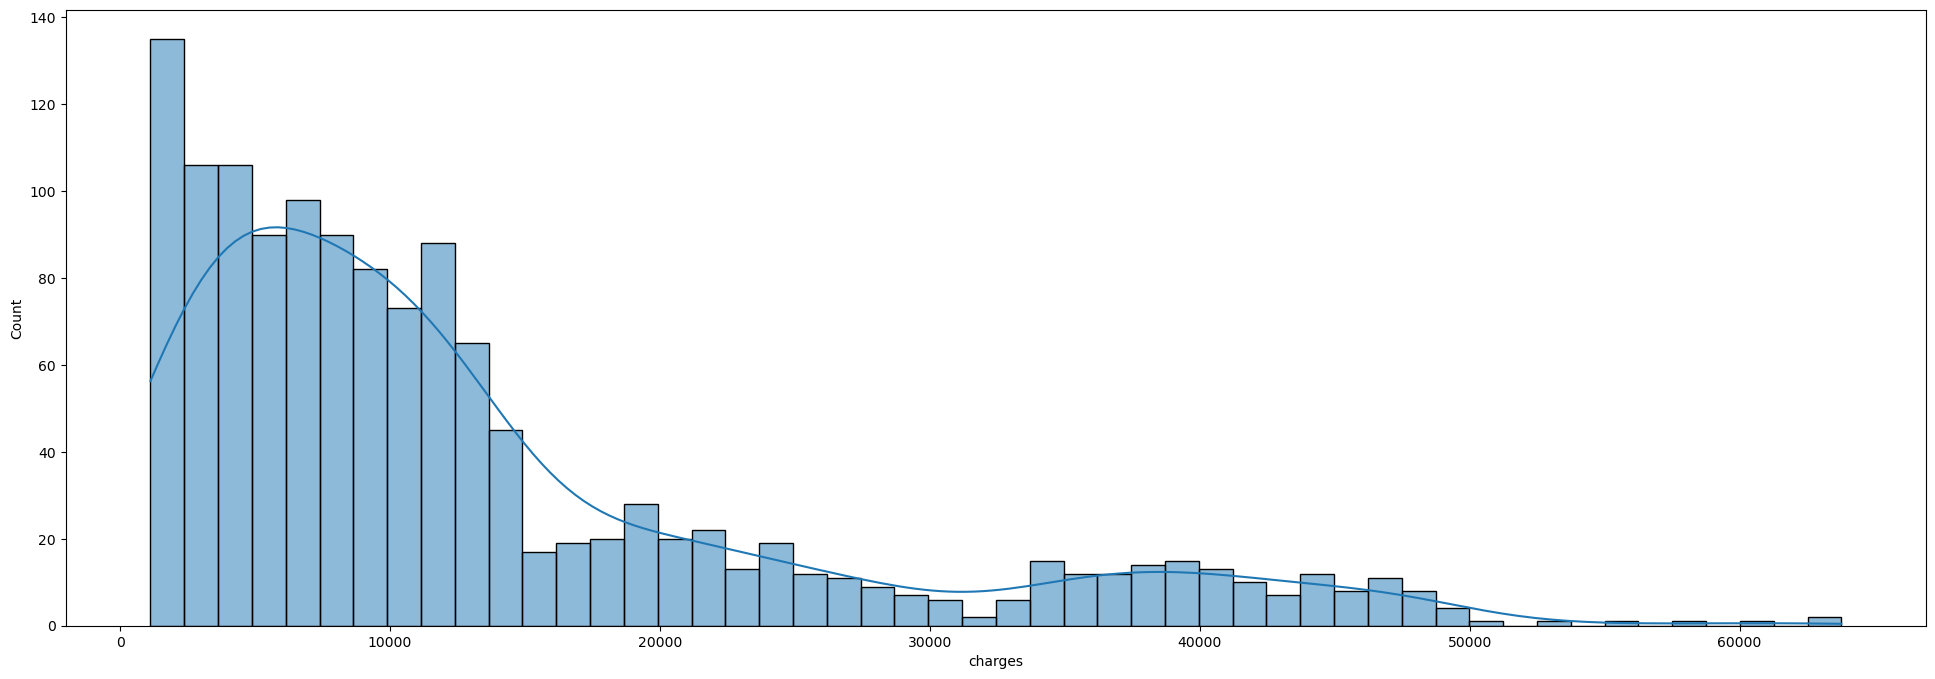

In [13]:
plt.figure(figsize=(24, 8))
sns.histplot(data=df, x='charges', bins=50 ,kde=True);
plt.show()

#### **Phân tích biểu đồ:**

##### 1. **Dạng phân phối:**

* Biểu đồ histogram cho thấy **phân phối lệch phải (right-skewed distribution)**.
* Phần lớn dữ liệu tập trung ở khoảng từ **0 đến 20,000**, với đỉnh cao nhất dưới **5,000**.
* Có **đuôi dài bên phải**, kéo dài đến hơn **60,000**, biểu thị sự xuất hiện của một số ít giá trị cực lớn (outliers).

##### 2. **KDE line:**

* Đường màu xanh KDE (đường cong mật độ) cho thấy xu hướng mượt mà hơn về phân phối.
* Đường này giúp hình dung rõ ràng hơn đỉnh phân phối và độ rộng đuôi.

##### 3. **Ý nghĩa thực tế:**

* Đa số cá nhân có **chi phí y tế thấp**, phản ánh nhóm dân cư không có vấn đề sức khỏe nghiêm trọng.
* Một nhóm nhỏ có chi phí y tế rất cao, có thể là:

  * Người mắc bệnh mãn tính.
  * Người lớn tuổi.
  * Có BMI cao hoặc hút thuốc (dễ mắc bệnh).

#### 3.2 tìm mối quan hệ giữa các biến với target

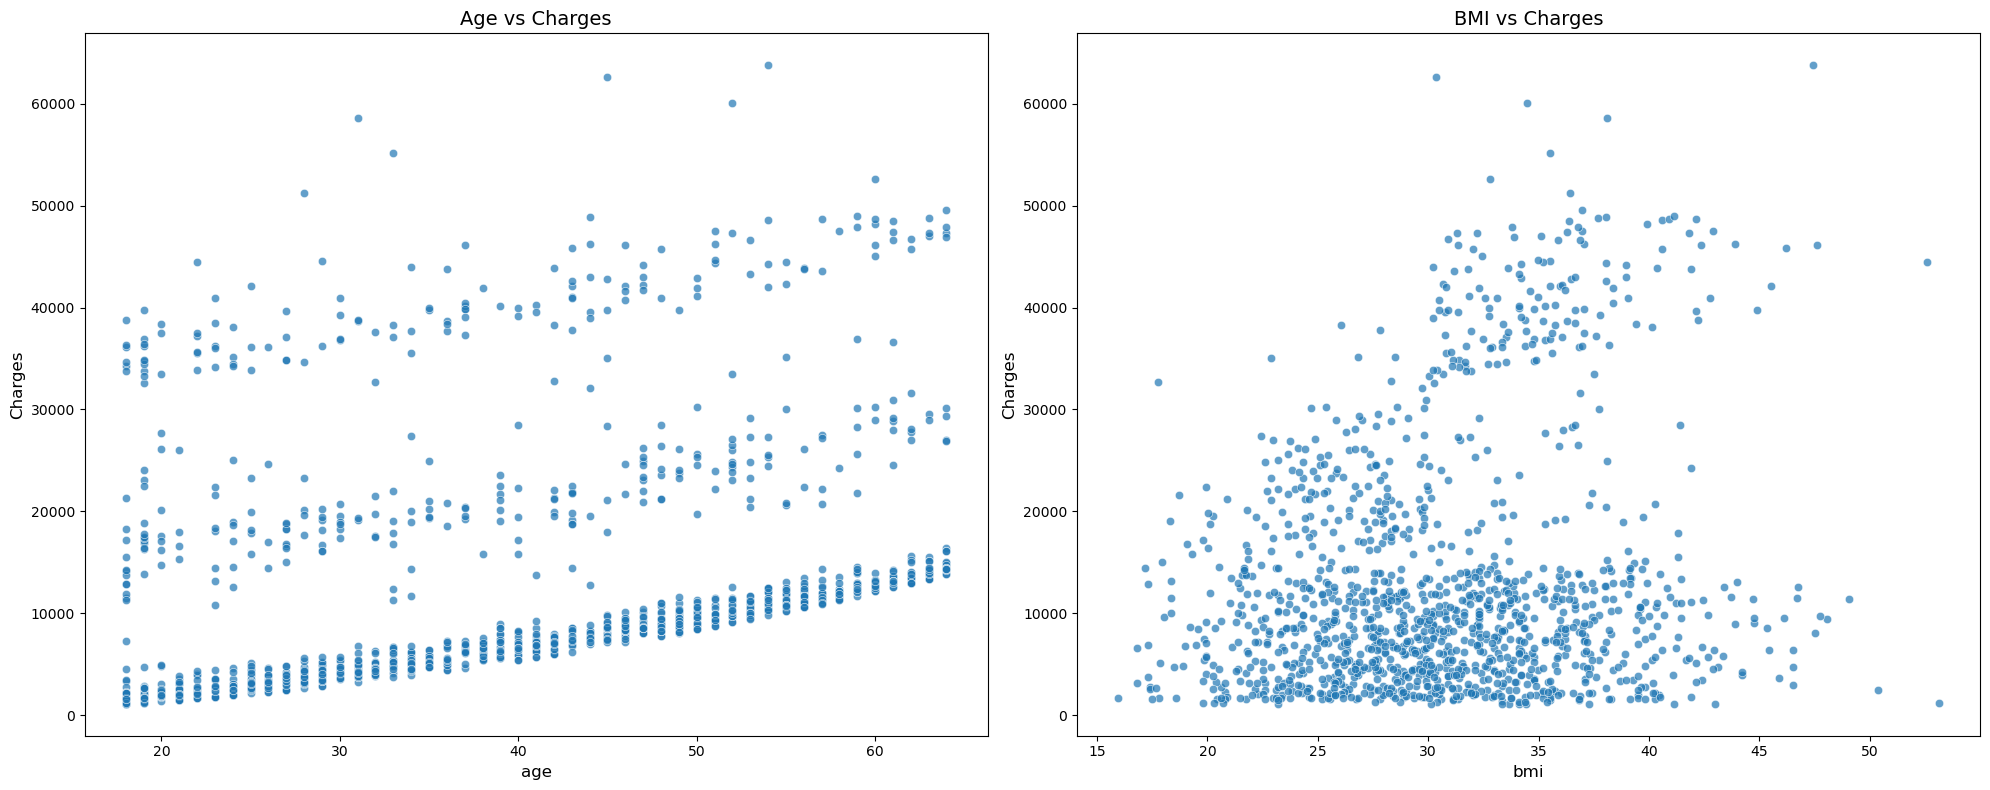

In [14]:
# Tạo figure và subplot
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

variables = ['age', 'bmi']
titles = ['Age vs Charges', 'BMI vs Charges']

# Lặp qua các biến liên tục để vẽ scatterplot
for i, var in enumerate(variables):
    sns.scatterplot(data=df, x=var, y='charges', ax=axes[i], alpha=0.7)
    axes[i].set_title(titles[i], fontsize=14)
    axes[i].set_xlabel(var, fontsize=12)
    axes[i].set_ylabel('Charges', fontsize=12)

# # Vẽ boxplot cho biến 'children'
# sns.boxplot(data=df, x='children', y='charges', ax=axes[2])
# axes[2].set_title('Children vs Charges (Boxplot)', fontsize=14)
# axes[2].set_xlabel('Children', fontsize=12)
# axes[2].set_ylabel('Charges', fontsize=12)

# Căn chỉnh layout
plt.tight_layout()
plt.show()

#### **Nhận xét về mối quan hệ giữa các biến và chi phí y tế (`charges`):**

**1. Age vs Charges:**
Biểu đồ cho thấy xu hướng **tăng tuyến tính nhẹ** giữa tuổi và chi phí y tế. Nhóm người lớn tuổi (đặc biệt từ 50 trở lên) có xu hướng phát sinh chi phí cao hơn, phản ánh nhu cầu chăm sóc sức khỏe gia tăng theo độ tuổi. Tuy nhiên, vẫn tồn tại nhiều điểm phân tán cho thấy các yếu tố khác cũng đóng vai trò quan trọng.

**2. BMI vs Charges:**
Không có xu hướng tuyến tính rõ rệt, nhưng có thể thấy rằng các cá nhân có **BMI cao hơn (trên 30)** – ngưỡng béo phì – thường gắn với chi phí y tế cao. Sự phân tán rộng tại vùng BMI cao gợi ý rằng **béo phì có thể là một yếu tố rủi ro chi phí y tế tăng vọt**.

      sex   charges
0  female 12,569.58
1    male 13,975.00 


  smoker   charges
0     no  8,440.66
1    yes 32,050.23 


      region   charges
0  northeast 13,406.38
1  northwest 12,450.84
2  southeast 14,735.41
3  southwest 12,346.94 


   children   charges
0         0 12,384.70
1         1 12,731.17
2         2 15,073.56
3         3 15,355.32
4         4 13,850.66
5         5  8,786.04 




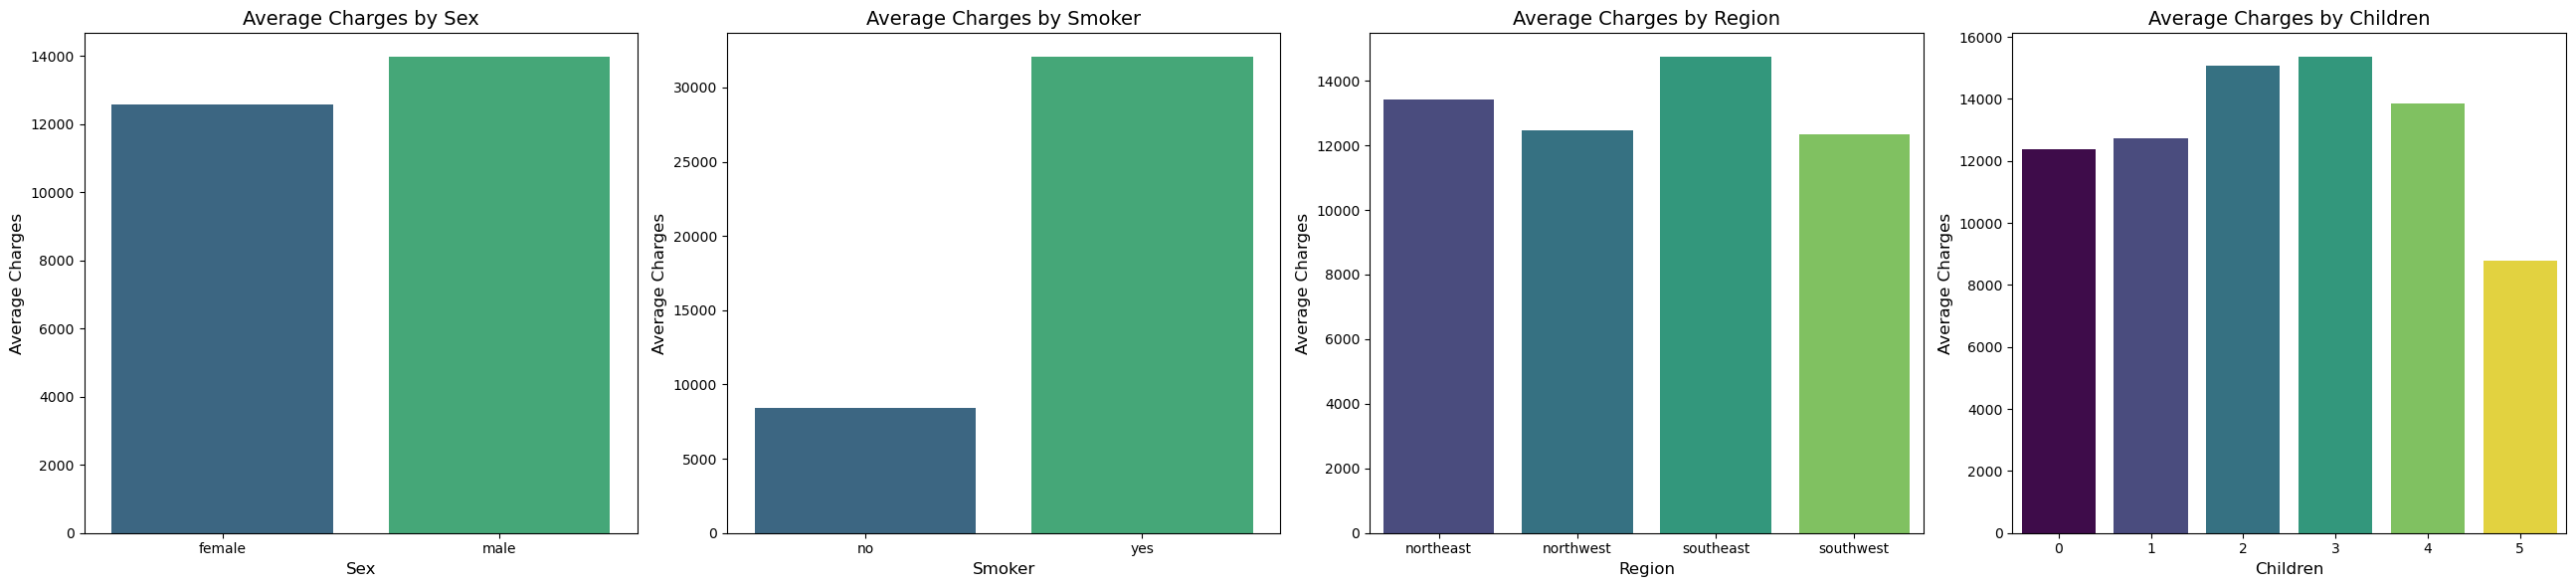

In [15]:
# Danh sách các cột phân loại (bao gồm children)
categorical_features = ['sex', 'smoker', 'region', 'children']

# Tạo figure với 1 hàng, 4 cột
fig, axes = plt.subplots(1, len(categorical_features), figsize=(26, 6))
axes = axes.flatten()

# Vẽ biểu đồ barplot cho từng biến
for i, feature in enumerate(categorical_features):
    # Tính trung bình charges theo từng nhóm
    grouped_data = df.groupby(feature)['charges'].mean().reset_index()
    print(grouped_data, "\n")
    print()

    # Vẽ barplot
    sns.barplot(data=grouped_data, x=feature, y='charges', ax=axes[i], palette='viridis', hue=feature, legend=False)
    axes[i].set_title(f'Average Charges by {feature.capitalize()}', fontsize=14)
    axes[i].set_ylabel('Average Charges', fontsize=12)
    axes[i].set_xlabel(feature.capitalize(), fontsize=12)

# Căn chỉnh layout
plt.tight_layout()
plt.show()


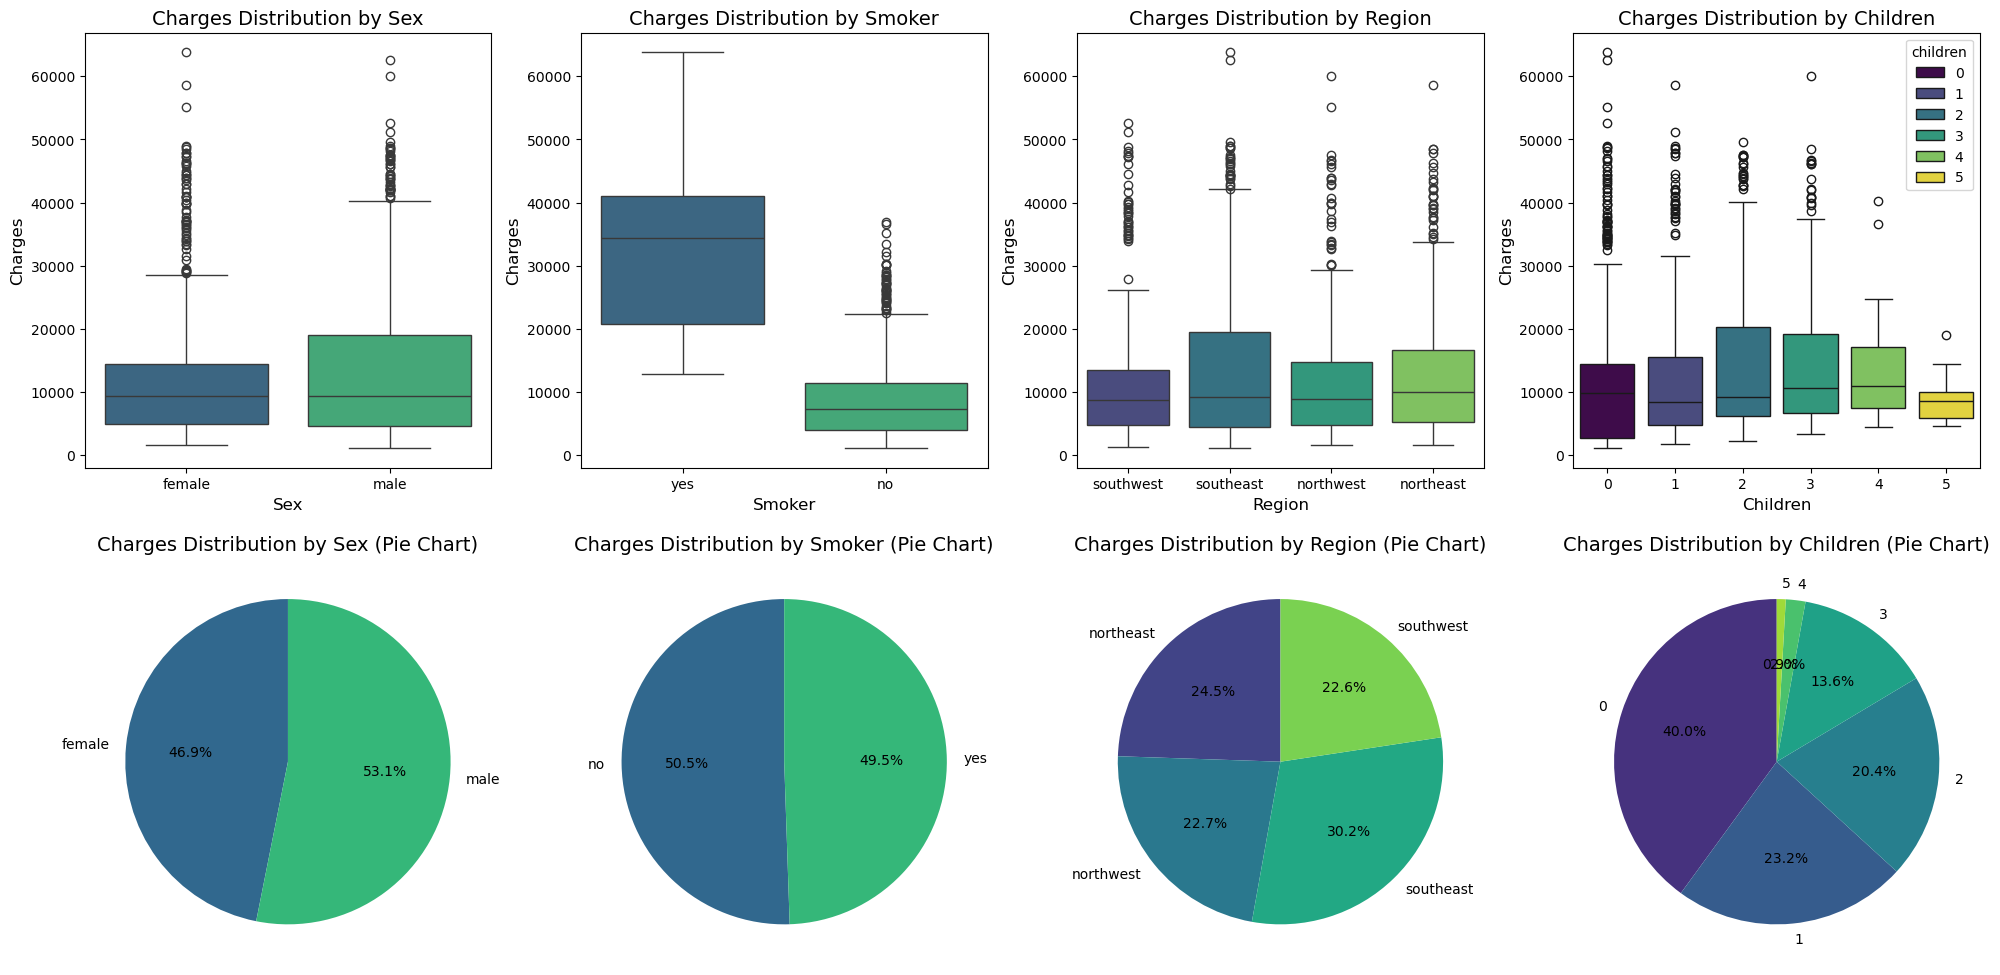

In [16]:
# Tạo figure với grid 2x3 (hàng 1: boxplots, hàng 2: pie charts)
rows, cols = 2, len(categorical_features)
fig, axes = plt.subplots(rows, cols, figsize=(20, 10))
axes = axes.flatten()

# Vẽ biểu đồ boxplot (hàng 1)
for i, feature in enumerate(categorical_features):
    sns.boxplot(data=df, x=feature, hue=feature, y='charges', ax=axes[i], palette='viridis')
    axes[i].set_title(f'Charges Distribution by {feature.capitalize()}', fontsize=14)
    axes[i].set_ylabel('Charges', fontsize=12)
    axes[i].set_xlabel(feature.capitalize(), fontsize=12)

# Vẽ biểu đồ tròn (hàng 2)
for i, feature in enumerate(categorical_features):
    # Tính tổng charges theo từng nhóm của biến phân loại
    pie_data = df.groupby(feature)['charges'].sum()

    # Vẽ pie chart
    axes[i + len(categorical_features)].pie(
        pie_data,
        labels=pie_data.index,
        autopct='%1.1f%%',
        startangle=90,
        colors=sns.color_palette('viridis', len(pie_data))
    )
    axes[i + len(categorical_features)].set_title(f'Charges Distribution by {feature.capitalize()} (Pie Chart)', fontsize=14)

# Căn chỉnh layout
plt.tight_layout()
plt.show()

#### **Phân tích tác động của các biến phân loại đến chi phí y tế (`charges`)**

##### **1. Giới tính (Sex):**

* **Chi phí trung bình** của nam (**13,975**) cao hơn nữ (**12,570**) – chênh lệch không quá lớn.
* **Boxplot** cho thấy cả hai nhóm có phân phối tương tự, tuy nhiên **nam giới có nhiều outlier ở mức cao hơn**, cho thấy chi phí y tế có thể dao động rộng hơn ở nhóm này.
* **Tỷ lệ giới tính** khá cân bằng (nam chiếm **53.1%**, nữ **46.9%**) → sự khác biệt chi phí giữa hai giới có thể đến từ yếu tố sức khỏe hoặc hành vi sử dụng dịch vụ y tế.

##### **2. Tình trạng hút thuốc (Smoker):**

* Đây là biến **ảnh hưởng mạnh nhất**: người hút thuốc có chi phí trung bình **32,050**, gần **4 lần** so với người không hút (**8,441**).
* Boxplot thể hiện rõ sự khác biệt: **độ phân tán lớn hơn, giá trị trung vị và cực đại đều cao hơn ở nhóm hút thuốc**.
* **Tỷ lệ smoker và non-smoker gần như bằng nhau** (49.5% vs 50.5%) → yếu tố hút thuốc là biến giải thích quan trọng và nên được đưa vào mô hình dự đoán chi phí.

##### **3. Khu vực sinh sống (Region):**

* **Southeast** có chi phí trung bình cao nhất (**14,735**), tiếp theo là **northeast** (**13,406**), thấp nhất là **southwest** (**12,347**).
* Tuy có sự khác biệt nhẹ về trung bình, nhưng **boxplot cho thấy phân phối charges giữa các vùng khá tương đồng**, đều có nhiều outlier.
* **Tỷ lệ mẫu** phân bố không đều: southeast chiếm **30.2%**, các vùng khác chiếm từ \~22% đến 24% → southeast có thể ảnh hưởng đến trung bình toàn bộ.

##### **4. Số lượng con (Children):**

* Trung bình chi phí không có **mối quan hệ tuyến tính rõ ràng** với số lượng con. Nhóm có 2–3 con có chi phí cao hơn một chút, nhưng nhóm có 5 con lại thấp nhất (**\~8,900**).
* Boxplot cho thấy **sự phân tán charges trong các nhóm là tương đối giống nhau**, nhưng số lượng outlier giảm dần theo số con.
* **Phân bố số lượng con** không đều: nhóm không có con chiếm **40%**, còn nhóm có 5 con rất ít (**0.2%**) → có thể gây sai lệch khi so sánh trung bình.

In [17]:
# One-hot encoding cột sex, smoker và region
df = pd.get_dummies(df, columns=['sex', 'smoker', 'region'], drop_first=True)

# Hiển thị DataFrame sau khi one-hot encode
df.head()

,age,bmi,children,charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,19,27.90,0,"16,884.92",False,True,False,False,True
1,18,33.77,1,"1,725.55",True,False,False,True,False
2,28,33.00,3,"4,449.46",True,False,False,True,False
3,33,22.70,0,"21,984.47",True,False,True,False,False
4,32,28.88,0,"3,866.86",True,False,True,False,False


##### _Xem hệ số tương quan giữa các biến_

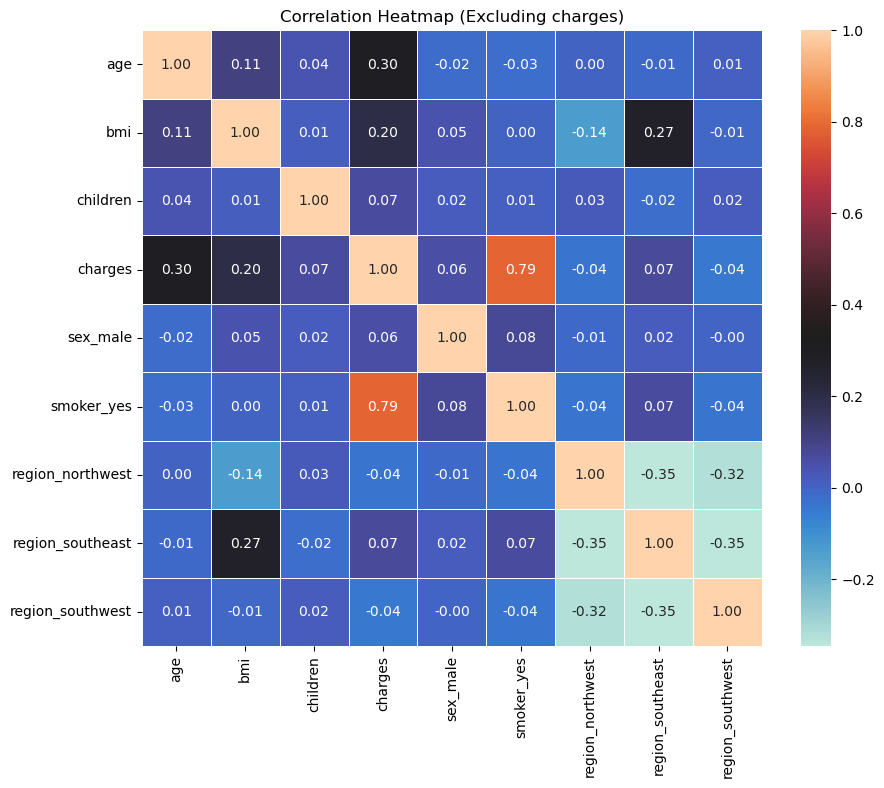

In [18]:
# Tính hệ số tương quan giữa các biến trong DataFrame và target
correlation_matrix = df.corr()

# Vẽ heatmap cho hệ số tương quan
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='icefire', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap (Excluding charges)')
plt.show()

# Lấy hệ số tương quan với target
target_correlation = correlation_matrix['charges']

# Sắp xếp và chọn 2 biến có hệ số tương quan cao nhất với target
top_correlations = target_correlation.sort_values(ascending=False)

In [19]:
# In ra các biến có hệ số tương quan cao với target, bỏ qua dòng đầu tiên
print(top_correlations.sort_values(ascending=False).iloc[1:])

smoker_yes          0.79
age                 0.30
bmi                 0.20
region_southeast    0.07
children            0.07
sex_male            0.06
region_northwest   -0.04
region_southwest   -0.04
Name: charges, dtype: float64


In [20]:
# Giả sử bạn đã có DataFrame df chứa các cột:
print(df.shape)
# Chuyển smoker_yes từ boolean sang numeric (0, 1)
df['smoker_yes'] = df['smoker_yes'].astype(int)

# Chọn các cột cần xử lý
columns = ['smoker_yes', 'age', 'bmi', 'charges']

# Tính toán Q1, Q3, và IQR cho từng cột
for col in columns:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1

    # Xác định outliers theo IQR
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Lọc dữ liệu để loại bỏ outliers
    df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

df['smoker_yes'] = df['smoker_yes'].astype(bool)

# Kiểm tra kết quả sau khi loại bỏ outliers
print(df.shape)

(1337, 9)
(1009, 9)


##### **Nhận xét tổng quát**


#### **Tổng kết:**
- Các biến **`smoker_yes`**, **`age`**, và **`bmi`** có mối tương quan mạnh mẽ hoặc trung bình với `charges`, cho thấy chúng có ảnh hưởng đáng kể đến chi phí bảo hiểm.
- Các biến còn lại như **`region`**, **`children`**, và **`sex_male`** có mối tương quan yếu hoặc rất yếu với `charges`.
- Điều này có thể gợi ý rằng các yếu tố như việc hút thuốc, độ tuổi và chỉ số BMI là các yếu tố quan trọng hơn trong việc xác định chi phí bảo hiểm, trong khi các yếu tố như khu vực sinh sống và số lượng trẻ em ít ảnh hưởng hơn.
-Việc bỏ biến có thể xem xét với một số biến có tương quan yếu với **`charges`**

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1009 entries, 1 to 1336
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   age               1009 non-null   int64  
 1   bmi               1009 non-null   float64
 2   children          1009 non-null   int64  
 3   charges           1009 non-null   float64
 4   sex_male          1009 non-null   bool   
 5   smoker_yes        1009 non-null   bool   
 6   region_northwest  1009 non-null   bool   
 7   region_southeast  1009 non-null   bool   
 8   region_southwest  1009 non-null   bool   
dtypes: bool(5), float64(2), int64(2)
memory usage: 44.3 KB


In [22]:
print("chênh lệch số dòng dữ liệu ban đầu là: ")
print(len(Insurance_data) - len(df))

chênh lệch số dòng dữ liệu ban đầu là: 
329


### 4. Modeling

In [23]:
# hồi quy
X = df.drop('charges', axis=1)
y = df['charges']

In [24]:
X

,age,bmi,children,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
1,18,33.77,1,True,False,False,True,False
2,28,33.00,3,True,False,False,True,False
3,33,22.70,0,True,False,True,False,False
4,32,28.88,0,True,False,True,False,False
5,31,25.74,0,False,False,False,True,False
...,...,...,...,...,...,...,...,...
1332,52,44.70,3,False,False,False,False,True
1333,50,30.97,3,True,False,True,False,False
1334,18,31.92,0,False,False,False,False,False
1335,18,36.85,0,False,False,False,True,False


In [25]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

#### 4.1 Mô hình hồi quy Ridge regression

In [26]:
def run_ridge_cv(data, target_col='charges', alpha=1.0, n_splits=5, return_score=False):
    # 1. Chuẩn bị dữ liệu
    X = data.drop(columns=[target_col]).copy()
    y = data[target_col].values

    # 2. Khởi tạo KFold
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=2025)
    mse_train, mse_test = [], []
    mae_train, mae_test = [], []
    r2_train, r2_test = [], []

    # 3. Train + Đánh giá từng fold
    for train_idx, test_idx in kf.split(X):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        model = Ridge(alpha=alpha)
        model.fit(X_train, y_train)

        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        #MSE
        mse_train.append(mean_squared_error(y_train, y_train_pred))
        mse_test.append(mean_squared_error(y_test, y_test_pred))

        # MAE
        mae_train.append(mean_absolute_error(y_train, y_train_pred))
        mae_test.append(mean_absolute_error(y_test, y_test_pred))

        # R²
        r2_train.append(r2_score(y_train, y_train_pred))
        r2_test.append(r2_score(y_test, y_test_pred))

    # 4. Tính trung bình
    avg_train_mse = np.mean(mse_train)
    avg_test_mse = np.mean(mse_test)
    avg_train_rmse = np.sqrt(avg_train_mse)
    avg_test_rmse = np.sqrt(avg_test_mse)
    avg_train_mae = np.mean(mae_train)
    avg_test_mae = np.mean(mae_test)
    avg_train_r2 = np.mean(r2_train)
    avg_test_r2 = np.mean(r2_test)

    # 5. Trả kết quả nếu dùng cho tối ưu hóa
    if return_score:
        return avg_test_r2

    # 6. Ngược lại, in kết quả chi tiết
    print("\n Ridge Regression Results (K-Fold CV)")
    print(f"Alpha: {alpha}")
    print(f"Average Train MSE: {avg_train_mse:.4f}, Test MSE: {avg_test_mse:.4f}")
    print(f"Average Train RMSE: {avg_train_rmse:.4f}, Test RMSE: {avg_test_rmse:.4f}")
    print(f"Average Train MAE : {avg_train_mae:.4f}, Test MAE : {avg_test_mae:.4f}")
    print(f"Average Train R²  : {avg_train_r2:.4f}, Test R²  : {avg_test_r2:.4f}")

In [27]:
run_ridge_cv(df, alpha=1)


 Ridge Regression Results (K-Fold CV)
Alpha: 1
Average Train MSE: 7870203.2687, Test MSE: 8045707.7645
Average Train RMSE: 2805.3883, Test RMSE: 2836.4957
Average Train MAE : 1337.3466, Test MAE : 1354.8386
Average Train R²  : 0.6079, Test R²  : 0.6051


#### Đánh giá hiệu suất của mô hình Ridge Regression:


In [28]:
%%time
from bayes_opt import BayesianOptimization

# Biến toàn cục lưu số luồng
n_jobs_value = None

def ask_for_njobs():
    global n_jobs_value
    try:
        user_input = int(input("Nhập số luồng CPU (-1 đến 7), bạn có 60 giây: "))
        if -1 <= user_input <= 7:
            n_jobs_value = user_input
        else:
            warnings.warn("Giá trị không hợp lệ. Dùng mặc định n_jobs = 2.")
    except:
        warnings.warn("Nhập sai định dạng. Dùng mặc định n_jobs = 2.")

# Gợi ý luồng nhập trong 60 giây
input_thread = threading.Thread(target=ask_for_njobs)
input_thread.start()
input_thread.join(timeout=60)

if n_jobs_value is None:
    print("⏰ Không nhập trong 60s. Dùng mặc định n_jobs = 2.")
    n_jobs_value = 2

# Hàm đánh giá duy nhất (ví dụ: Ridge, RF hoặc XGB)
def model_cv(alpha):
    return run_ridge_cv(
        df,
        alpha=alpha,
        n_splits=5,
        return_score=True
    )

# Cấu hình Bayesian Optimization
model_bo = BayesianOptimization(
    f=model_cv,
    pbounds={
        'alpha': (0.00001, 10)  # Thay đổi tùy mô hình
    },
    random_state=2025
)

# Tối ưu hóa
print("🔍 Đang tối ưu mô hình Ridge...")
model_bo.maximize(init_points=5, n_iter=25)

# In kết quả cuối cùng
print("\n Tham số tốt nhất:")
print(model_bo.max)


⏰ Không nhập trong 60s. Dùng mặc định n_jobs = 2.
🔍 Đang tối ưu mô hình Ridge...
|   iter    |  target   |   alpha   |
-------------------------------------
| 1         | 0.6052    | 1.355     |
| 2         | 0.6054    | 8.879     |
| 3         | 0.6054    | 9.326     |
| 4         | 0.6053    | 4.456     |
| 5         | 0.6053    | 3.882     |
| 6         | 0.6054    | 10.0      |
| 7         | 0.6054    | 9.999     |
| 8         | 0.6054    | 9.999     |
| 9         | 0.6054    | 10.0      |
| 10        | 0.6054    | 9.999     |
| 11        | 0.6054    | 9.998     |
| 12        | 0.6054    | 9.997     |
| 13        | 0.6054    | 10.0      |
| 14        | 0.6054    | 10.0      |
| 15        | 0.6054    | 10.0      |
| 16        | 0.6054    | 10.0      |
| 17        | 0.6054    | 10.0      |
| 18        | 0.6054    | 9.999     |
| 19        | 0.6054    | 10.0      |
| 20        | 0.6054    | 10.0      |
| 21        | 0.6054    | 9.998     |
| 22        | 0.6054    | 9.999     |
| 23   

Nhập số luồng CPU (-1 đến 7), bạn có 60 giây:  -1


In [29]:
%%time

# Lấy tham số tối ưu từ kết quả BO
best_params = model_bo.max['params']
best_alpha = float(best_params['alpha'])  # Ép kiểu an toàn

# Gọi lại mô hình Ridge với tham số tối ưu
run_ridge_cv(
    data=df,               # hoặc data_binned nếu bạn dùng tên khác
    target_col='charges',
    alpha=best_alpha,
    n_splits=5,
    return_score=False       # Để in kết quả thay vì trả về
)



 Ridge Regression Results (K-Fold CV)
Alpha: 9.999924605207005
Average Train MSE: 7873643.6517, Test MSE: 8040458.9398
Average Train RMSE: 2806.0014, Test RMSE: 2835.5703
Average Train MAE : 1336.6795, Test MAE : 1353.7548
Average Train R²  : 0.6077, Test R²  : 0.6054
CPU times: total: 375 ms
Wall time: 44.6 ms


In [30]:
run_ridge_cv(df, alpha=1)


 Ridge Regression Results (K-Fold CV)
Alpha: 1
Average Train MSE: 7870203.2687, Test MSE: 8045707.7645
Average Train RMSE: 2805.3883, Test RMSE: 2836.4957
Average Train MAE : 1337.3466, Test MAE : 1354.8386
Average Train R²  : 0.6079, Test R²  : 0.6051


#### **So sánh kết quả Ridge Regression (K-Fold CV)**

| Chỉ số         | Alpha = 1 (mặc định) | Alpha = 9.9999 (tối ưu BO)   |
| -------------- | -------------------- | ---------------------------- |
| **Train RMSE** | 2805.39              | **2806.00**       |
| **Test RMSE**  | 2836.50              | **2835.57**  |
| **Train MAE**  | 1337.35              | **1336.68**        |
| **Test MAE**   | 1354.84              | **1353.75**        |
| **Train R²**   | 0.6079               | **0.6077**    |
| **Test R²**    | 0.6051               | **0.6054**         |



#### **Kết luận:**

* **Alpha = 9.9999** là giá trị tốt hơn về mặt tổng thể, nhưng mức cải thiện không đáng kể.
* Ridge Regression cho thấy **hiệu suất ổn định**,cân nhắc thêm các mô hình phi tuyến như **Random Forest hoặc XGBoost** để kiểm tra khả năng cải thiện.